# Data reduction and 3D analysis


In this tutorial, we present the basics steps for a 3D stacked analysis. The main aim is to perform a spectral and morphological analysis of a given source. We are going to analyse the data from the High Energy Stereoscopic System (H.E.S.S.) towards the SNR RX J1713.7-3946. 

Let's start with some basic imports:

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
import numpy as np

from gammapy.data import DataStore
from gammapy.datasets import MapDataset, Datasets
from gammapy.estimators import ExcessMapEstimator
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)

In [ ]:
data_store = DataStore.from_dir(f"$GAMMAPY_DATA/hess-dl3-dr1")

Lets look at the information for that datastore.

In [ ]:
data_store.info()

In [ ]:
target_position = SkyCoord.from_name("RX J1713.7-3946").galactic

### What are the galactic coordinates of this source?

We can now define an observation filter to select only the relevant observations. Here we use a cone search which we define with a python dict.

We then filter the ObservationTable with `~gammapy.data.ObservationTable.select_observations()`.


In [ ]:
selection = dict(
    type="sky_circle",
    frame=XXX,
    lon=XXX,
    lat=XXX,
    radius="5 deg",
)
selected_obs_table = XXX

### Look at what is in that selected table


We can now retrieve the relevant observations by passing their obs_id to the `~gammapy.data.DataStore.get_observations()` method.


### View those observations

# Preparing reduced datasets geometry

We define a reference geometry for our analysis.

We choose a WCS based geometry. We define the center of the geometry by our target source, assign a binsize of 0.02 deg, the width of the geometry, and also define an energy axis.

This geometry will be what our final dataset will look like.

In [ ]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_axis],
)

Important: we have both a 'true' energy axis and 'reconstructed' energy axis. We must ensure that the true axis is both wider in energy and contains more bins than the 'reco'.

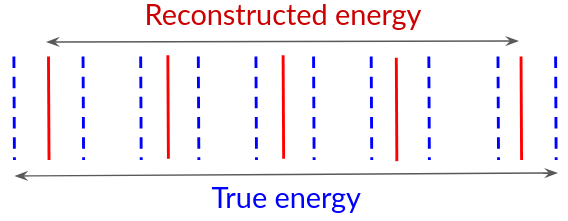

### Define the true energy axis based on the above information

In [ ]:
energt_axis_true = 

In [ ]:
print(geom)


# Data reduction - FoV background method!

Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.


In [ ]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="rxj-stacked"
)

We need to mask out any sources with significant emission.

You can check the http://gamma-sky.net to see if there are sources in the FoV and create an exclusion region based that.

In [ ]:
regions = 
exclusion_mask = ~geom.region_mask(regions=regions)

## Try to plot the exclusion mask

Create the `makers`.

In [ ]:
maker = MapDatasetMaker(
    selection=["counts", "background", "psf", "edisp", "exposure"]
)
safe_mask_maker = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max="2.3 deg"
)
fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

### Perform the data reduction loop recalling the order:
- maker
- safe mask
- FoVbkg

In [ ]:
for obs in observations:
    dataset = 
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    stacked.stack(dataset)

In [ ]:
print(stacked)

We can save this file so that later you can manipulate it!

In [ ]:
stacked.write("stacked_MapDataset.fits")

We can also `peek` this, just like we did with the observations.

In [ ]:
stacked.peek()

It looks like we have some source based on the counts image but it is hard to discern. This is because we have a map with very fine binning, so to view this better we can plot (for example) a counts map which has been smoothed.

In [ ]:
stacked.counts.reduce_over_axes().smooth(0.05 * u.deg).plot(add_cbar=True)
plt.show()

Note: in the about plot I utilised the `reduce_over_axes` functionality. If you print the shape of the `counts` object, you will see that we have a third axis in energy which has the same amount of bins as we first defined for our `geom`. This function will reduce the non-spatial axes of the map (i.e. the energy axis), such that it just has 1 bin and can be plotted as a 2D figure with the `plot` functionality.



## Compute an excess and a significance map

In [ ]:
estimator = ExcessMapEstimator(
    0.1 * u.deg, selection_optional=[], energy_edges=[0.4, 20] * u.TeV
)
maps = estimator.run(stacked)

In [ ]:
maps.sqrt_ts.plot(add_cbar=True)
plt.show()

### We can plot the excess and significance maps

In [ ]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=maps.sqrt_ts.geom.wcs)
ax2 = plt.subplot(222, projection=maps.sqrt_ts.geom.wcs)

ax1.set_title("Significance map")
maps.sqrt_ts.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
maps.npred_excess.plot(ax=ax2, add_cbar=True)

# Can you create a map for the flux now?

Recall: it is possible to have autocompletion suggestions. Try it yourself with writing `maps.` and then press crtl+space

# What about a map in different energy bins?

### Bonus: plot the exclusion mask on top of the image to ensure we excluded all significant emission from the background when we created the dataset

The exclusion mask was created based off a `region` so we can utilise its functionality to plot it. 

### Well done!! You have gone from DL3 data products to a DL4 dataset, which can be used for SCIENCE! 🥳


## Lets do some science!

# Exercises: 3D modeling - fit a model to our dataset


The 3D analysis consists of a simultaneous fit of the spectral and spatial parameters of one or multiple sources. Here, we focus only on a single source, centered at the coordinates l=347.269°, b=-0.257°. To perform the fit, we firstly need to define a model: we can try with a Gaussian morphology and a powerlaw spectral shape.

You can utilise the 'tab' completion on the following cell to see which model are available to use. Note: they are named according to their type so you can guess what the 'Gaussian' morphology model should be called.

In [ ]:
from gammapy.modeling.models import 

In [ ]:
spatial_model = 

### 1 - Show on the map that this is a suitable guess for the emission extension and position

### 2 - Create a spectral model, use a simple PowerLaw here. 

In [ ]:
spectral_model = 

We limit the model position inside a 1 deg box centered on the reference position of RX J1713

In [ ]:
spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5

### 3 - Limit the `lat_0` values yourself

In [ ]:
from gammapy.modeling.models import SkyModel, FoVBackgroundModel, Models

In [ ]:
sky_model = SkyModel(
    spectral_model=spectral_model, spatial_model=spatial_model, name="rxj"
)

Now, we define a global ~gammapy.modeling.model.FoVBackgroundModel in order to finely adjust the level of residual CR backgroud. This should not be forgotten.

Note: we assume the background is well know and can be taken from the IRF bkg model


In [ ]:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)

Now we assign these models to our reduced dataset:

In [ ]:
stacked.models = Models([sky_model, bkg_model])

### 4 - Look at your stacked dataset. It should now contain information on the models we just applied

### 5 - Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its constructor takes a list of dataset as argument.

### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few options on the dataset object to handle this. First we can use `.plot_residuals_spatial()` to plot a residual image, summed over all energies:

In [ ]:
region = CircleSkyRegion(center=target_position, radius=0.4 * u.deg)
stacked.plot_residuals(kwargs_spectral={"region": region});

### 6 - Plot the fitted spectrum

Making a butterfly plot

The SpectralModel component can be used to produce a, so-called, butterfly plot showing the envelope of the model taking into account parameter uncertainties:


### 7 - Computing flux points

We can now compute some flux points using the ~gammapy.estimators.FluxPointsEstimator.

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name.


## More advanced 

### 8 - Source significance

What is the TS-based significance of this source? You can estimate it by comparing the model likelihood without (null hypothesis) and with the source model

### 9 - Does the source exhibit energy-dependent morphology? 

A dedicated estimator has been implemented to answer to this question, EnergyDependentMorphologyEstimator